<a href="https://colab.research.google.com/github/puweiliao/Machine-learning/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
    def plot_loss(history):
        print("plotting loss")
        plt.plot(history.history['loss'], label='loss')
        plt.plot(history.history['val_loss'], label='val_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss/Validation Loss')
        plt.legend(loc='upper right')
        plt.pause(0.001)
        plt.show()



In [ ]:
    def plot_mse(history):
        print("plotting MSE")
        plt.plot(history.history['MSE'], label='MSE')
        plt.plot(history.history['val_MSE'], label='val_MSE')
        plt.xlabel('Epoch')
        plt.ylabel('MSE')
        plt.title('MSE/Validation MSE')
        plt.legend(loc='upper right')
        plt.pause(0.001)
        plt.show()

In [ ]:
import os
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dropout, Dense, LSTM


class LongShortTermMemory:
    def __init__(self, project_folder):
        self.project_folder = project_folder

    def get_defined_metrics(self):
        defined_metrics = [
            tf.keras.metrics.MeanSquaredError(name='MSE')
        ]
        return defined_metrics

    def get_callback(self):
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
        return callback

    def create_model(self, x_train):
        model = Sequential()

        model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], 1)))

        model.add(Dropout(0.2))

        model.add(LSTM(units=50, return_sequences=True))

        model.add(Dropout(0.2))

        model.add(LSTM(units=50, return_sequences=True))
        
        model.add(Dropout(0.5))

        model.add(LSTM(units=50))
        
        model.add(Dropout(0.5))
        
        model.add(Dense(units=1))
        
        model.summary()
        #tf.keras.utils.plot_model(model, to_file=os.path.join(self.project_folder, 'model_lstm.png'), show_shapes=True,
        #                          show_layer_names=True)
        return model

In [ ]:
from google.colab import drive 

drive.mount('/content/gdrive/') 

Mounted at /content/gdrive/


[[[0.88050458]
  [0.85085037]
  [0.81486338]]

 [[0.85085037]
  [0.81486338]
  [0.77016309]]

 [[0.81486338]
  [0.77016309]
  [0.71222763]]

 ...

 [[0.18773745]
  [0.18697171]
  [0.2107875 ]]

 [[0.18697171]
  [0.2107875 ]
  [0.19833418]]

 [[0.2107875 ]
  [0.19833418]
  [0.20213063]]]
[0.77016309 0.71222763 0.70174642 0.63971896 0.70743706 0.70597544
 0.70549451 0.68761923 0.66665682 0.67424165 0.67561192 0.64985626
 0.54982536 0.57882802 0.53607566 0.57949434 0.54629893 0.55286279
 0.55850506 0.5438835  0.54945324 0.58971493 0.61601601 0.62486364
 0.62035251 0.60927752 0.57982751 0.62283511 0.6368414  0.64417367
 0.61238077 0.63542814 0.6349069  0.608407   0.59248502 0.59358661
 0.59709288 0.59958892 0.58390607 0.51450066 0.58678363 0.59743411
 0.60045138 0.65286816 0.65211317 0.66935974 0.6353556  0.66628604
 0.67051506 0.64078562 0.63182514 0.63647868 0.57013891 0.51743196
 0.57063597 0.60690508 0.59103684 0.6020503  0.59100459 0.60131653
 0.59712512 0.58862946 0.52963406 0.484643

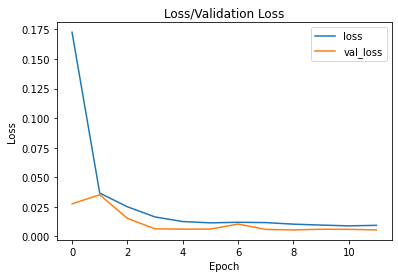

plotting MSE


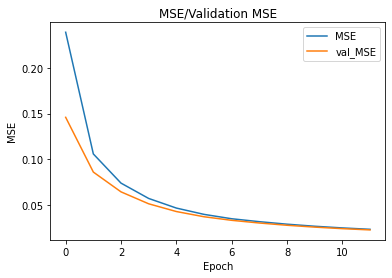

In [ ]:
import pandas as pd
import secrets
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

TIME_STEPS = 3

pd.options.mode.chained_assignment = None

fields = ['timestamp', 'Asset_ID', 'Close']
train_df = pd.read_csv("/content/gdrive/MyDrive/train.csv", low_memory=False, 
                       dtype={'Asset_ID': 'int8', 'Count': 'int32', 'row_id': 'int32', 'Count': 'int32', 
                              'Open': 'float64', 'High': 'float64', 'Low': 'float64', 'Close': 'float64', 
                              'Volume': 'float64', 'VWAP': 'float64'
                             }
                      , nrows=8000
                      , usecols=fields)

train_df.dropna(axis = 0, inplace = True)


# For Asset BTC
train_btc = train_df[train_df['Asset_ID'] == 1]
del train_btc['Asset_ID']

# Split the data set
training_data = train_btc[:int(train_btc.shape[0]*0.7)].copy()
test_data = train_btc[int(train_btc.shape[0]*0.7):].copy()

training_data = training_data.set_index('timestamp')
test_data = test_data.set_index('timestamp')

min_max = MinMaxScaler(feature_range=(0, 1))
train_scaled = min_max.fit_transform(training_data)


# Training Data Transformation
x_train = []
y_train = []
for i in range(TIME_STEPS, train_scaled.shape[0]):
    x_train.append(train_scaled[i - TIME_STEPS:i])
    y_train.append(train_scaled[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

total_data = pd.concat((training_data, test_data), axis=0)
inputs = total_data[len(total_data) - len(test_data) - TIME_STEPS:]
test_scaled = min_max.fit_transform(inputs)

# Testing Data Transformation
x_test = []
y_test = []
for i in range(TIME_STEPS, test_scaled.shape[0]):
    x_test.append(test_scaled[i - TIME_STEPS:i])
    y_test.append(test_scaled[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print(x_train)
print(y_train)

STOCK_TICKER = 'BTC'
TODAY_RUN = datetime.today().strftime("%Y%m%d")
TOKEN = STOCK_TICKER + '_' + TODAY_RUN + '_' + secrets.token_hex(16)
PROJECT_FOLDER = os.path.join(os.getcwd(), TOKEN)

if not os.path.exists(PROJECT_FOLDER):
    os.makedirs(PROJECT_FOLDER)
        

# Train the model
EPOCHS = 100
BATCH_SIZE = 32
lstm = LongShortTermMemory(PROJECT_FOLDER)
model = lstm.create_model(x_train)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=lstm.get_defined_metrics())
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(x_test, y_test),
                    callbacks=[lstm.get_callback()])
print("saving weights")
model.save(os.path.join(PROJECT_FOLDER, 'model_weights.h5'))
plot_loss(history)
plot_mse(history)

In [ ]:
price_predict=model.predict(x_test)

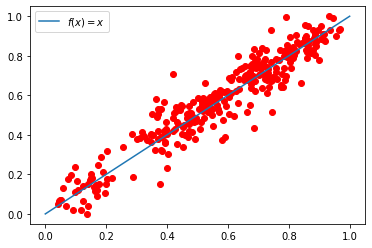

In [ ]:
plt.scatter(price_predict, y_test, c='r')
def f(x):
  return x

fx_name = r'$f(x)={x}$'


x=np.linspace(0,1)

y=f(x)

plt.plot(x, y, label=fx_name)

plt.legend(loc='upper left')


plt.show()

